<a href="https://colab.research.google.com/github/Drewe4401/Movie-Recommender-System/blob/main/Movie_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install turicreate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install imdbpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast 
import turicreate as tc
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
import imdb

import warnings; warnings.simplefilter('ignore')

In [ ]:
movie = pd.read_csv('movies_metadata.csv', low_memory = False)
links = pd.read_csv('links.csv', low_memory = False)
ratings = pd.read_csv('ratings.csv', low_memory = False)

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [ ]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [ ]:
movie.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
data = pd.merge(ratings, links)
data.groupby('movieId')['rating'].mean().sort_values(ascending=False).head()

movieId
176271    5.0
73730     5.0
71322     5.0
71606     5.0
26383     5.0
Name: rating, dtype: float64

In [ ]:
movie['genres'] = movie['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i[
    'name'] for i in x] if isinstance(x, list) else [])

In [ ]:
vote_counts = movie[movie['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = movie[movie['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
m = vote_counts.quantile(0.80)

In [ ]:
movie['year'] = pd.to_datetime(movie['release_date'], errors='coerce').apply(
    lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [ ]:
qualified = movie[(movie['vote_count'] >= m) & (movie['vote_count'].notnull()) & (movie['vote_average'].notnull())][['title', 
'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(3103, 6)

In [ ]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
qualified['WR'] = qualified.apply(weighted_rating, axis=1)
qualified = qualified.sort_values('WR', ascending=False).head(250)

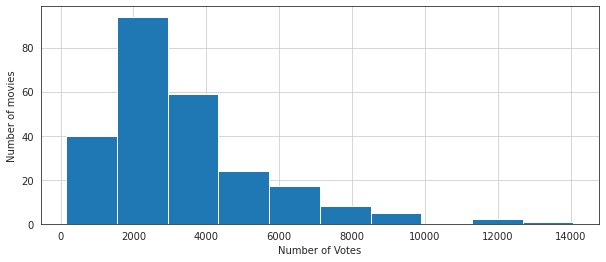

In [ ]:
sns.set_style('white')
plt.figure(figsize = (10, 4))
plt.xlabel("Number of Votes")
plt.ylabel("Number of movies")
qualified['vote_count'].hist(bins = 10)

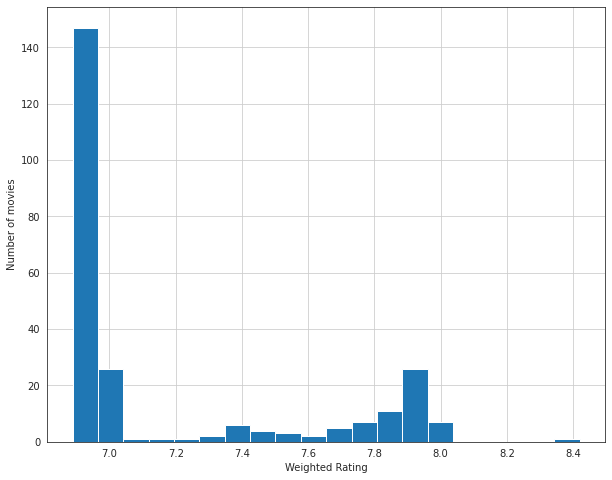

In [ ]:
plt.figure(figsize = (10, 8))
plt.xlabel("Weighted Rating")
plt.ylabel("Number of movies")
qualified['WR'].hist(bins = 20)

In [ ]:
qualified.head(50)

,title,year,vote_count,vote_average,popularity,genres,WR
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,"[Comedy, Drama, Romance]",8.420415
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.977159
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.973834
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.966928
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.964050
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.963144
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.961790
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.961187
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.960817
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.958269


In [ ]:
ratings = ratings.drop('timestamp', axis=1)
ratings.head()

,userId,movieId,rating
0,1,110,1.0
1,1,147,4.5
2,1,858,5.0
3,1,1221,5.0
4,1,1246,5.0


In [ ]:
ratings.describe()

,userId,movieId,rating
count,697799.000000,697799.000000,697799.000000
mean,3604.814904,16464.146943,3.548192
std,2044.121831,31615.758224,1.035557
min,1.000000,1.000000,0.500000
25%,1832.000000,1079.000000,3.000000
50%,3713.000000,2672.000000,3.500000
75%,5378.000000,6773.000000,4.000000
max,7107.000000,176271.000000,5.000000


In [ ]:
groupWA = pd.DataFrame()
groupdata = pd.DataFrame(ratings.groupby('movieId')['rating'].mean())
groupdata.head()

,rating
movieId,
1,3.903480
2,3.219750
3,3.167901
4,2.824324
5,3.064165


In [ ]:
groupdata['number_of_ratings'] = ratings.groupby('movieId')['rating'].count()
groupdata.head(50)

,rating,number_of_ratings
movieId,,
1,3.903480,1839
2,3.219750,719
3,3.167901,405
4,2.824324,74
5,3.064165,413
6,3.863329,739
7,3.327146,431
8,3.288889,45
9,2.959677,124


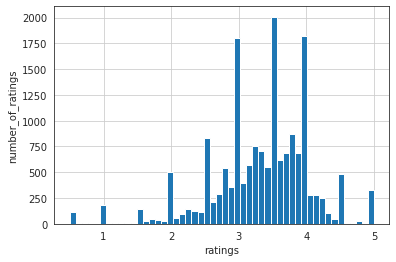

In [ ]:
plt.xlabel('ratings')
plt.ylabel('number_of_ratings')
groupdata['rating'].hist(bins=50)

In [ ]:
rating_average = groupdata[groupdata['rating'].notnull()]['rating'].astype('float')
vote_averages = groupdata[groupdata['number_of_ratings'].notnull()]['number_of_ratings'].astype('int')
m = vote_averages.quantile(.80)
c = rating_average.mean()

In [ ]:
def weighted_rating(x):
    v = x['number_of_ratings']
    R = x['rating']
    return (v/(v+m) * R) + (m/(m+v) * c)

In [ ]:
groupdata['WR'] = groupdata.apply(weighted_rating, axis=1)
groupdata = groupdata.sort_values('WR', ascending=False).head(250)

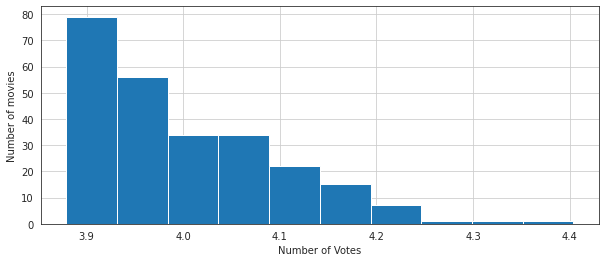

In [ ]:
sns.set_style('white')
plt.figure(figsize = (10, 4))
plt.xlabel("Number of Votes")
plt.ylabel("Number of movies")
groupdata['WR'].hist(bins = 10)

In [ ]:
ratingstc = tc.SFrame.read_csv('ratings.csv')

Finished parsing file /content/ratings.csv

Parsing completed. Parsed 100 lines in 2.27893 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,float,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 2006281 lines. Lines per second: 744514

Read 9857999 lines. Lines per second: 1.26573e+06

Successfully parsed 3 tokens: 
	0: 136300
	1: 237
	2: 3

1 lines failed to parse correctly

Finished parsing file /content/ratings.csv

Parsing completed. Parsed 13116704 lines in 8.94862 secs.

In [ ]:
ratingstc = ratingstc.remove_column('timestamp')

In [ ]:
ratingstc = ratingstc.rename({ 'userId': 'user_id', 'movieId' : 'item_id'})
ratingstc

user_id,item_id,rating
1,110,1.0
1,147,4.5
1,858,5.0
1,1221,5.0
1,1246,5.0
1,1968,4.0
1,2762,4.5
1,2918,5.0
1,2959,4.0
1,4226,4.0


In [ ]:
model = tc.item_similarity_recommender.create(ratingstc, target='rating')

Preparing data set.

Data has 861355 observations with 8776 users and 19695 items.

Data prepared in: 1.81526s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 6.613ms                        | 11.25      |

| 83.014ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.04s                               | 0                | 0               |

| 5.04s                               | 25.25            | 4987            |

| 8.10s                               | 49.5             | 9764            |

| 11.05s                              | 67               | 13205           |

| 14.05s                              | 89.75            | 17681           |

| 21.04s                              | 100              | 19695           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 22.1392s

In [ ]:
modelcosine = tc.item_similarity_recommender.create(ratingstc, target='rating', similarity_type='cosine')

Preparing data set.

Data has 861355 observations with 8776 users and 19695 items.

Data prepared in: 0.875506s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 16.592ms                       | 11.25      |

| 57.242ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 453.415ms                           | 0                | 0               |

| 3.46s                               | 37.5             | 7393            |

| 6.46s                               | 70               | 13797           |

| 13.69s                              | 100              | 19695           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 13.8087s

In [ ]:
modelpearson = tc.item_similarity_recommender.create(ratingstc, target='rating', similarity_type='pearson')

Preparing data set.

Data has 861355 observations with 8776 users and 19695 items.

Data prepared in: 0.869777s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 21.887ms                       | 11.25      |

| 80.241ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 524.102ms                           | 0                | 0               |

| 3.52s                               | 28.75            | 5673            |

| 6.53s                               | 54.75            | 10829           |

| 9.52s                               | 79.25            | 15618           |

| 16.41s                              | 100              | 19695           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 16.5045s

In [ ]:
usertable = ratings.loc[ratings['userId'] == 10]
usertable = pd.merge(usertable, links)
usertable

,userId,movieId,rating,imdbId,tmdbId
0,10,150,4.0,112384,568.0
1,10,153,3.0,112462,414.0
2,10,165,4.0,112864,1572.0
3,10,296,5.0,110912,680.0
4,10,344,4.0,109040,3049.0
5,10,349,5.0,109444,9331.0
6,10,380,5.0,111503,36955.0
7,10,457,4.0,106977,5503.0
8,10,588,5.0,103639,812.0
9,10,590,3.0,99348,581.0


In [ ]:
ia = imdb.IMDb()

result = []
for value in usertable['imdbId']:
  search = ia.get_movie(value)
  result.append(search['title'])

result

['Apollo 13',
 'Batman Forever',
 'Die Hard with a Vengeance',
 'Pulp Fiction',
 'Ace Ventura: Pet Detective',
 'Clear and Present Danger',
 'True Lies',
 'The Fugitive',
 'Aladdin',
 'Dances with Wolves',
 'Batman',
 'The Silence of the Lambs',
 'Beauty and the Beast']

In [ ]:
usertable['Title'] = result
sf10 = tc.SFrame({'user_id':[10,10,10,10,10,10,10,10,10,10,10,10,10], 'item_id':[150,153,165,296,344,349,380,457,588,590,592,593,595], 'rating': [4,3,4,5,4,5,5,4,5,3,4,4,5]})
usertable

,userId,movieId,rating,imdbId,tmdbId,Title
0,10,150,4.0,112384,568.0,Apollo 13
1,10,153,3.0,112462,414.0,Batman Forever
2,10,165,4.0,112864,1572.0,Die Hard with a Vengeance
3,10,296,5.0,110912,680.0,Pulp Fiction
4,10,344,4.0,109040,3049.0,Ace Ventura: Pet Detective
5,10,349,5.0,109444,9331.0,Clear and Present Danger
6,10,380,5.0,111503,36955.0,True Lies
7,10,457,4.0,106977,5503.0,The Fugitive
8,10,588,5.0,103639,812.0,Aladdin
9,10,590,3.0,99348,581.0,Dances with Wolves


In [ ]:
finalresults = model.recommend(users=[10], k = 10)
item_id = list(finalresults['item_id'])
score = list(finalresults['score'])
rank = list(finalresults['rank'])

resultdata = {'movieId' : item_id,
              'score' : score,
              'rank' : rank}
resultdata = pd.DataFrame(resultdata)
resultdata = pd.merge(resultdata, links)

tempresult = []
for value in resultdata['imdbId']:
  search = ia.get_movie(value)
  tempresult.append(search['title'])

resultdata['Title'] = tempresult

In [ ]:
def pearson_correlation(matrix, user1, users):
  shared_items={}
  for item in matrix[user1]:
    if item in matrix[users]: shared_items[item] = 1

    if len(shared_items)==0: return 0

    sum1 = sum([pow(matrix[user1][it],2) for it in shared_items])
    sum2 = sum([pow(matrix[users][it],2) for it in shared_items])

    pSum = sum([matrix[user1][it]*matrix[users][it] for it in shared_items])

    numerator = pSum - (sum1*sum2/n)
    denominator = sqrt((sum1^2-pow(sum1,2)/n)*(sum2^2-pow(sum2,2)/n))
    if denominator==0: return 0

    r = numerator/denominator

    return r



In [ ]:
resultdata = resultdata.drop('movieId', axis = 1)
resultdata = resultdata.drop('imdbId', axis = 1)
resultdata = resultdata.drop('tmdbId', axis = 1)
resultdata

,score,rank,Title
0,0.384393,1,Speed
1,0.382217,2,Jurassic Park
2,0.381461,3,Dumb and Dumber
3,0.369984,4,Stargate
4,0.364361,5,Terminator 2: Judgment Day
5,0.363587,6,The Lion King
6,0.353984,7,Forrest Gump
7,0.348493,8,The Mask
8,0.347474,9,Braveheart
9,0.347081,10,Waterworld


In [ ]:
finalresults = modelcosine.recommend(users=[10], k = 10)
item_id = list(finalresults['item_id'])
score = list(finalresults['score'])
rank = list(finalresults['rank'])

resultdata = {'movieId' : item_id,
              'score' : score,
              'rank' : rank}
resultdata = pd.DataFrame(resultdata)
resultdata = pd.merge(resultdata, links)

tempresult = []
for value in resultdata['imdbId']:
  search = ia.get_movie(value)
  tempresult.append(search['title'])

resultdata['Title'] = tempresult

In [ ]:
resultdata = resultdata.drop('movieId', axis = 1)
resultdata = resultdata.drop('imdbId', axis = 1)
resultdata = resultdata.drop('tmdbId', axis = 1)
resultdata

,score,rank,Title
0,2.314368,1,Jurassic Park
1,2.261607,2,Speed
2,2.185677,3,Terminator 2: Judgment Day
3,2.173804,4,Forrest Gump
4,2.158229,5,The Lion King
5,2.135712,6,Dumb and Dumber
6,2.130371,7,Braveheart
7,2.076169,8,The Mask
8,2.054199,9,Se7en
9,2.048572,10,The Shawshank Redemption


In [ ]:
finalresults = modelpearson.recommend(users=[10], k = 10)
item_id = list(finalresults['item_id'])
score = list(finalresults['score'])
rank = list(finalresults['rank'])

resultdata = {'movieId' : item_id,
              'score' : score,
              'rank' : rank}
resultdata = pd.DataFrame(resultdata)
resultdata = pd.merge(resultdata, links)

tempresult = []
for value in resultdata['imdbId']:
  search = ia.get_movie(value)
  tempresult.append(search['title'])

resultdata['Title'] = tempresult

In [ ]:
resultdata = resultdata.drop('movieId', axis = 1)
resultdata = resultdata.drop('imdbId', axis = 1)
resultdata = resultdata.drop('tmdbId', axis = 1)
resultdata

,score,rank,Title
0,5.0,1,Palm Trees in the Snow
1,5.0,2,Dragonquest
2,5.0,3,Valerie and Her Week of Wonders
3,5.0,4,My Mom Is a Character
4,5.0,5,The Woman in Black
5,5.0,6,"Refugee All Stars, Sierra Leone's"
6,5.0,7,The Genius of Marian
7,5.0,8,The Ear
8,5.0,9,Big Boys Gone Bananas!*
9,5.0,10,Christine


In [ ]:
eval = modelcosine.evaluate(sf10)
eval


Precision and recall summary statistics by cutoff
+--------+----------------+-------------+
| cutoff | mean_precision | mean_recall |
+--------+----------------+-------------+
|   1    |      0.0       |     0.0     |
|   2    |      0.0       |     0.0     |
|   3    |      0.0       |     0.0     |
|   4    |      0.0       |     0.0     |
|   5    |      0.0       |     0.0     |
|   6    |      0.0       |     0.0     |
|   7    |      0.0       |     0.0     |
|   8    |      0.0       |     0.0     |
|   9    |      0.0       |     0.0     |
|   10   |      0.0       |     0.0     |
+--------+----------------+-------------+
[10 rows x 3 columns]


Overall RMSE: 2.2566857154787754

Per User RMSE (best)
+---------+--------------------+-------+
| user_id |        rmse        | count |
+---------+--------------------+-------+
|    10   | 2.2566857154787754 |   13  |
+---------+--------------------+-------+
[1 rows x 3 columns]


Per User RMSE (worst)
+---------+--------------------+

{'precision_recall_by_user': Columns:
 	user_id	int
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 18
 
 Data:
 +---------+--------+-----------+--------+-------+
 | user_id | cutoff | precision | recall | count |
 +---------+--------+-----------+--------+-------+
 |    10   |   1    |    0.0    |  0.0   |   13  |
 |    10   |   2    |    0.0    |  0.0   |   13  |
 |    10   |   3    |    0.0    |  0.0   |   13  |
 |    10   |   4    |    0.0    |  0.0   |   13  |
 |    10   |   5    |    0.0    |  0.0   |   13  |
 |    10   |   6    |    0.0    |  0.0   |   13  |
 |    10   |   7    |    0.0    |  0.0   |   13  |
 |    10   |   8    |    0.0    |  0.0   |   13  |
 |    10   |   9    |    0.0    |  0.0   |   13  |
 |    10   |   10   |    0.0    |  0.0   |   13  |
 +---------+--------+-----------+--------+-------+
 [18 rows x 5 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 